# **Nairobi Air Quality Time Series Analysis** *using Auto Regressive and ARMA models and database from MongoDB*

## 1. Defining the Question

### a) Specifying the Question

To build a time series model to make prediction using Auto Regressive and ARMA models

### b) Defining the Metric for Success

To get a model that can achieve the highest level of prediction

### c) Understanding the context

The Sensors.AFRICA Air Quality Archive - Nairobi dataset provides critical insights into air quality, specifically particulate matter (PM2.5 and PM10), temperature, and humidity. Particulate matter, especially PM2.5 (≤ 2.5 micrometers), is a primary pollutant due to its ability to penetrate the lungs and bloodstream, causing diseases like bronchitis, asthma, lung cancer, and cardiovascular issues (WHO, 2021).

Sensors.AFRICA uses low-cost sensors to enhance public access to environmental data. Geolocated and timestamped, the data enables spatial and temporal air pollution analyses. Nairobi faces significant air quality challenges due to rapid urbanization, vehicle emissions, and industrial activities (UNEP, 2019).

Despite their promise, low-cost sensors have limitations. Studies by Castell et al. (2017) and Borrego et al. (2016) highlight calibration needs and the potential to complement traditional monitoring systems (Castell et al., 2017; Borrego et al., 2016). Leveraging such data supports policy formulation, urban planning, and public health interventions.

**References**
1. World Health Organization (WHO), 2021. Ambient (Outdoor) Air Pollution and Health.
2. United Nations Environment Programme (UNEP), 2019. Air Quality in Nairobi City. 
3. Castell, N., et al., 2017. Can low-cost sensors complement regulatory air quality monitoring networks? Insights from urban Europe. Atmospheric Measurement Techniques, 10(10), 3889–3894. DOI: 10.5194/amt-10-3889-2017.
4. Borrego, C., et al., 2016. Assessment of air quality microsensors versus reference methods: The EuNetAir joint exercise. Atmospheric Environment, 147, 246-263. DOI: 10.1016/j.atmosenv.2016.02.021.


### d) Data Relevance

The dataset from April 2023 to Match 2024 and can be found from the [Sensors.AFRICA Air Quality Archive - Nairobi](https://open.africa/dataset/sensorsafrica-airquality-archive-nairobi) but I have merged the files for the individual months and save them in a localhost MongoDB service. 

This data set contains PM (particulate matter), temperature, and humidity readings taken with low-cost sensors. These sensors measure the concentration of PM in the air, including particles with diameters less than or equal to 1 micrometer (PM1), 2.5 micrometers (PM2.5), and particles with diameters less than or equal to 10 micrometers (PM10). The data set includes information on the sensor type, date, time, and location of the readings, as well as the sensor’s specific measurement values for Temperature (C), Humidity (%), PM1, PM2.5, and PM10. The data set is ideal for researchers and individuals interested in studying air quality and low-cost sensors in PM measurement. 

**Note:** P0 in the data represents PM1, P2 represents PM2.5, and P1 represents PM10

<span style="color: green;">*We shall use PM2.5 for our analysis since it is the most critical metric for public health as it represents particles small enough to penetrate the lungs and enter the bloodstream.*<span>


## 2. Reading the Data

### 2.1.  Importing libraries

In [40]:
import pandas as pd
from pymongo import MongoClient
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=2)
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from pymongo import MongoClient
import time
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter(action="ignore", category=FutureWarning)

### 2.2. Loading the Data from MongoDB

In [5]:
# Create a client that connects to MongoDB
client = MongoClient(host="localhost", port=27017)

In [6]:
# Checking the databases
pp.pprint(list(client.list_databases()))

[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 332992512},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 61440},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 40960}]


In [7]:
# Creating a database
db = client["air-quality"]

In [8]:
# Creating a collection
nairobi = db["nairobi"]

In [9]:
# Checking the number of documents

print("We have", nairobi.count_documents({}), "documents in our database")

We have 8352880 documents in our database


In [10]:
# CHecking one record in Nairobi

result = nairobi.find_one({})
pp.pprint(result)

{ '_id': ObjectId('6773d1e219dd651155fd73fa'),
  'lat': -1.289,
  'location': 3573,
  'lon': 36.825,
  'sensor_id': 49,
  'sensor_type': 'pms5003',
  'timestamp': datetime.datetime(2023, 11, 1, 0, 0, 10, 706000),
  'value': 20.6,
  'value_type': 'P2'}


In [11]:
# Checking number of disntinct sites

nairobi.distinct("sensor_id")

[49,
 50,
 51,
 52,
 79,
 80,
 87,
 88,
 103,
 104,
 138,
 139,
 140,
 141,
 158,
 159,
 160,
 173,
 174,
 175,
 176,
 177,
 178,
 223,
 224,
 499,
 500,
 792,
 793,
 800,
 801,
 908,
 909,
 4820,
 4821,
 4849,
 4850]

In [12]:
# Number of sites in Nairobi

result = nairobi.aggregate(
        [
            {"$group": {"_id":"$sensor_id", "count":{"$count":{}}}}
        
        ]

)
pp.pprint(list(result))

[ {'_id': 141, 'count': 25308},
  {'_id': 50, 'count': 1501595},
  {'_id': 51, 'count': 1566},
  {'_id': 176, 'count': 208686},
  {'_id': 4821, 'count': 486},
  {'_id': 138, 'count': 717384},
  {'_id': 909, 'count': 32},
  {'_id': 104, 'count': 167262},
  {'_id': 801, 'count': 192524},
  {'_id': 80, 'count': 7546},
  {'_id': 88, 'count': 3274},
  {'_id': 178, 'count': 301101},
  {'_id': 500, 'count': 5790},
  {'_id': 140, 'count': 39084},
  {'_id': 177, 'count': 201128},
  {'_id': 223, 'count': 18018},
  {'_id': 4850, 'count': 42540},
  {'_id': 103, 'count': 167271},
  {'_id': 4849, 'count': 66009},
  {'_id': 4820, 'count': 735},
  {'_id': 792, 'count': 94131},
  {'_id': 173, 'count': 299430},
  {'_id': 174, 'count': 466378},
  {'_id': 79, 'count': 11328},
  {'_id': 159, 'count': 133796},
  {'_id': 49, 'count': 2252143},
  {'_id': 224, 'count': 33335},
  {'_id': 499, 'count': 3846},
  {'_id': 160, 'count': 246771},
  {'_id': 175, 'count': 134460},
  {'_id': 52, 'count': 1234},
  {'_id'

In [13]:
# Select sensor with highest count

result = nairobi.aggregate(
        [
            {"$group": {"_id":"$sensor_id", "count":{"$count":{}}}},
            {"$sort":{"count":-1}},
            {"$limit":1}
        
        ]

)
pp.pprint(list(result))

[{'_id': 49, 'count': 2252143}]


<span style="color: green;"> *We shall use sensor 49 since it has the highest number of records* <span>

## 3. Data Wrangling

In [14]:
# Create a function to wrangle the data

def wrangle_data(collection):
    results = collection.find(
        {"sensor_id": 49, "value_type": "P2"},
        projection={"timestamp": 1, "_id": 0, 'value': 1},
    )    
    
    df = pd.DataFrame(results)
    
    # Rename value column to PM2.5
    df = df.rename(columns={"value": "PM2.5"})
    
    # Convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    # Set timestamp as index
    df = df.set_index("timestamp")
    
     # Localizing the timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    
    # Removing outliers
    df = df[df["PM2.5"] < 150]
    
    # Resample to one hour period and filling missing values
    df = df["PM2.5"].resample("1H").mean().fillna(method="ffill").to_frame()
    
    # Adding a lag feature of 1 hour
    df["PM2.5_P1"] = df["PM2.5"].shift(1)
    
    # Dropping rows with missing values
    df = df.dropna()
    
    return df

In [15]:
# Loading an checking the top 5 records
df = wrangle_data(nairobi)

df.head()

,PM2.5,PM2.5_P1
timestamp,,
2023-04-01 04:00:00+03:00,15.981416,14.256195
2023-04-01 05:00:00+03:00,21.759735,15.981416
2023-04-01 06:00:00+03:00,29.433186,21.759735
2023-04-01 07:00:00+03:00,32.407965,29.433186
2023-04-01 08:00:00+03:00,31.027876,32.407965


In [16]:
# Checking the shape and information of the dataset

print(df.shape)
print(df.info())

(8476, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8476 entries, 2023-04-01 04:00:00+03:00 to 2024-03-19 07:00:00+03:00
Freq: h
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     8476 non-null   float64
 1   PM2.5_P1  8476 non-null   float64
dtypes: float64(2)
memory usage: 198.7 KB
None


## 4. Exploratory Data Analysis(EDA)

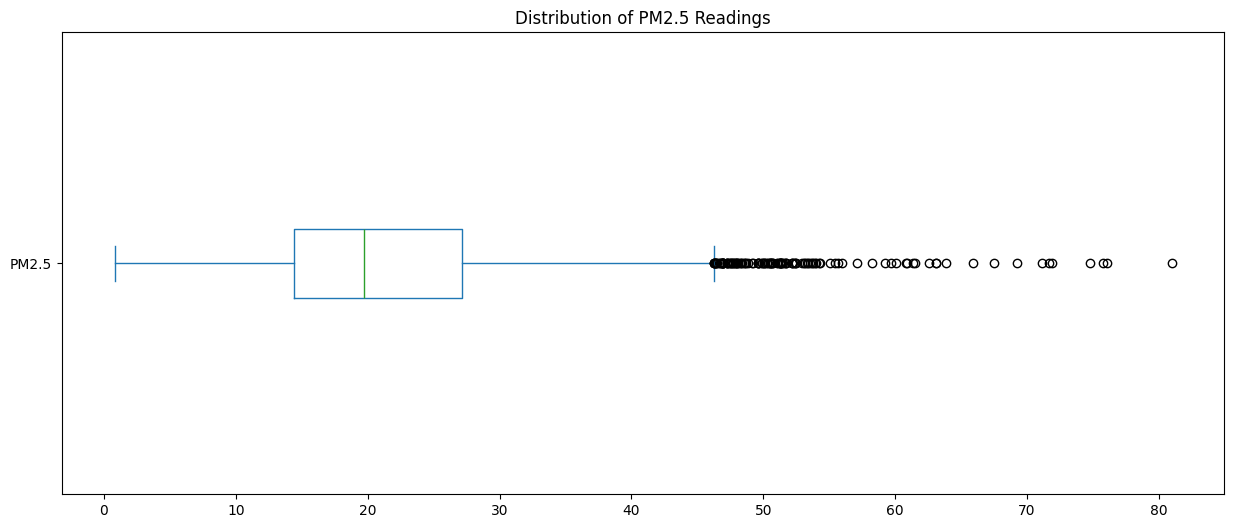

In [17]:
# Drawing a box plot to visualize the distribution

fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);

We can clearly see that we have many outliers in our dataset and this may affect our analysis. 

<span style="color: green;"> I shall remove any recording above 150 since any reading above that may imply that the air is unhealthy t breath and this may not be the case since we have few data ponts above that. I will use the above wrangle_data function to remove the outliers. <span> 

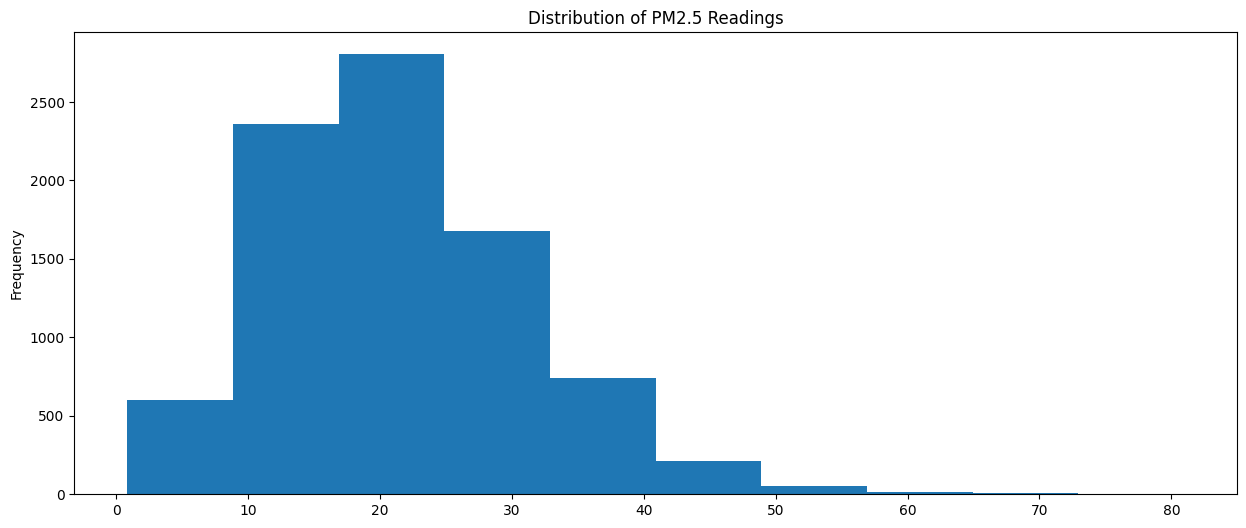

In [18]:
# Drawing a histogram to visualize the distribution

fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].plot(kind="hist", title="Distribution of PM2.5 Readings", ax=ax);

We can see that our data is still slightly skewed to the right. This means our median is bigger than our mean as clearly shown below that means we still have some outliers but the may not affect our analysis.

In [19]:
# Checking mean and median

print(df["PM2.5"].mean())
print(df["PM2.5"].median())

21.356075878838258
19.732817413522014


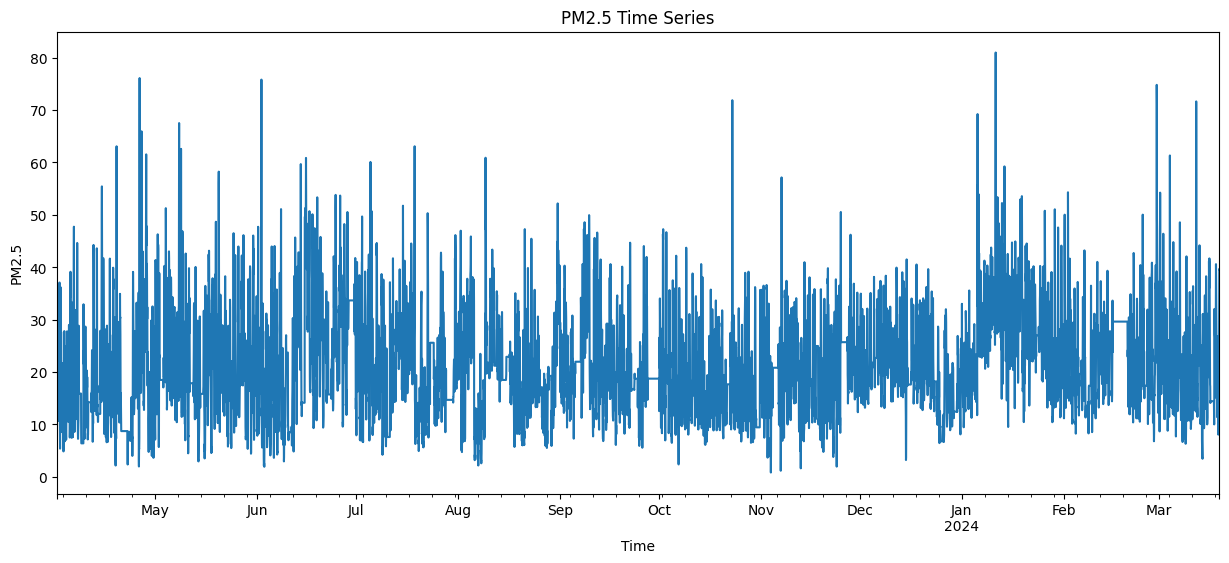

In [20]:
# Plotting the time series

fig, ax = plt.subplots(figsize=(15, 6))

df["PM2.5"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series",ax=ax);

We can see from the above that our Time series data is very noisy hence we shall proceed to use the rolling average as we check further on the data.

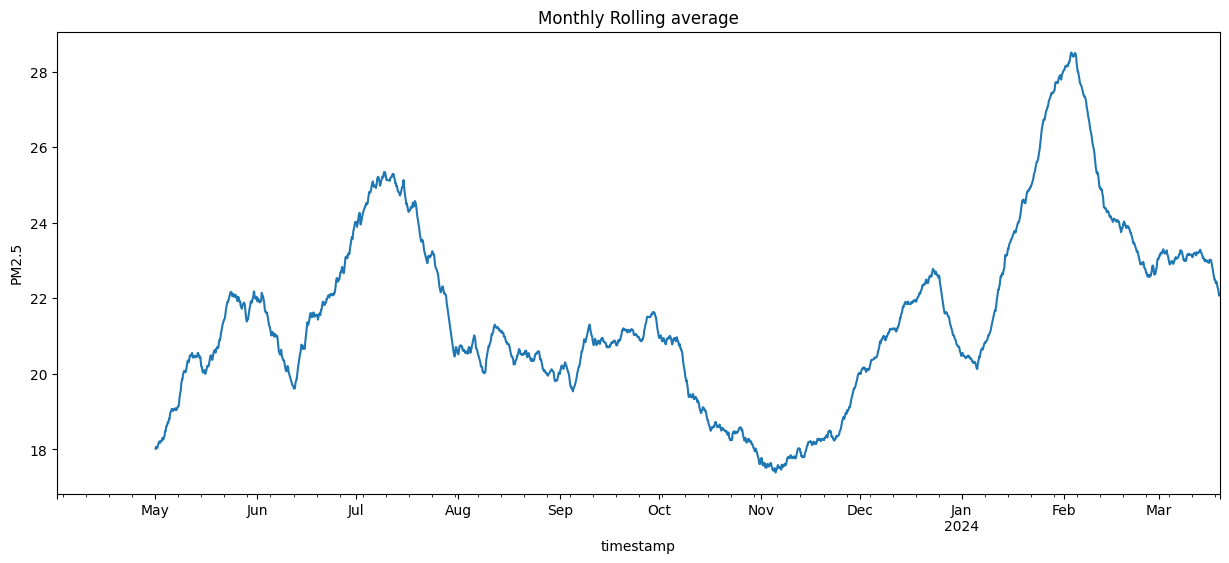

In [21]:
# We shall look at the monthly rolling average

fig, ax = plt.subplots(figsize=(15, 6))
df["PM2.5"].rolling(720).mean().plot(ax=ax,xlabel="timestamp",ylabel="PM2.5",title="Monthly Rolling average");

We still cannot be able to see any seasonal trend on the data.

<span style="color: green;"> We shall add lag of one hour feature on our wrangle_data function for our time series analysis. <span>


In [22]:
# Checking our updated wrangle data function

df = wrangle_data(nairobi)
print(df.shape)
print(df.info())
df.head()

(8476, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8476 entries, 2023-04-01 04:00:00+03:00 to 2024-03-19 07:00:00+03:00
Freq: h
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PM2.5     8476 non-null   float64
 1   PM2.5_P1  8476 non-null   float64
dtypes: float64(2)
memory usage: 198.7 KB
None


,PM2.5,PM2.5_P1
timestamp,,
2023-04-01 04:00:00+03:00,15.981416,14.256195
2023-04-01 05:00:00+03:00,21.759735,15.981416
2023-04-01 06:00:00+03:00,29.433186,21.759735
2023-04-01 07:00:00+03:00,32.407965,29.433186
2023-04-01 08:00:00+03:00,31.027876,32.407965


We shall plot an Autocorrelation scatter plot to visualize the relationship of PM2.5 and PM2.5_P1

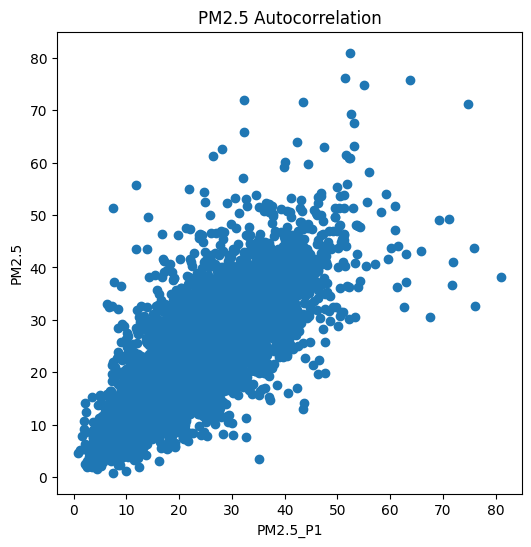

In [23]:
# Plotting scatterplot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x=df["PM2.5_P1"], y=df["PM2.5"])
plt.xlabel("PM2.5_P1")
plt.ylabel("PM2.5")
plt.title("PM2.5 Autocorrelation");

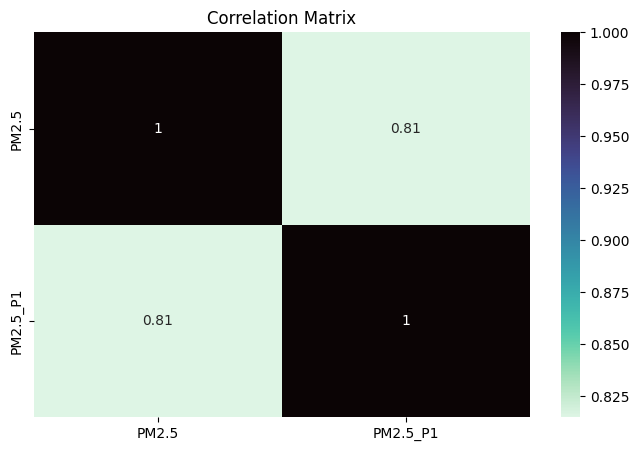

In [24]:
# Plotting the Correlation Matrix

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap="mako_r");
plt.title("Correlation Matrix");

We can see the two features are exhibiting Autocorrelation since their correlation coefficient is very at 0.81

<span style="color: green;"> We shall proceed to plot our ACF. This means to treat the Autocorrelation as a function this enables us to see the change over time. <span>

In [25]:
# We shall first change our dataframe to 1 dimension

y = df["PM2.5"]

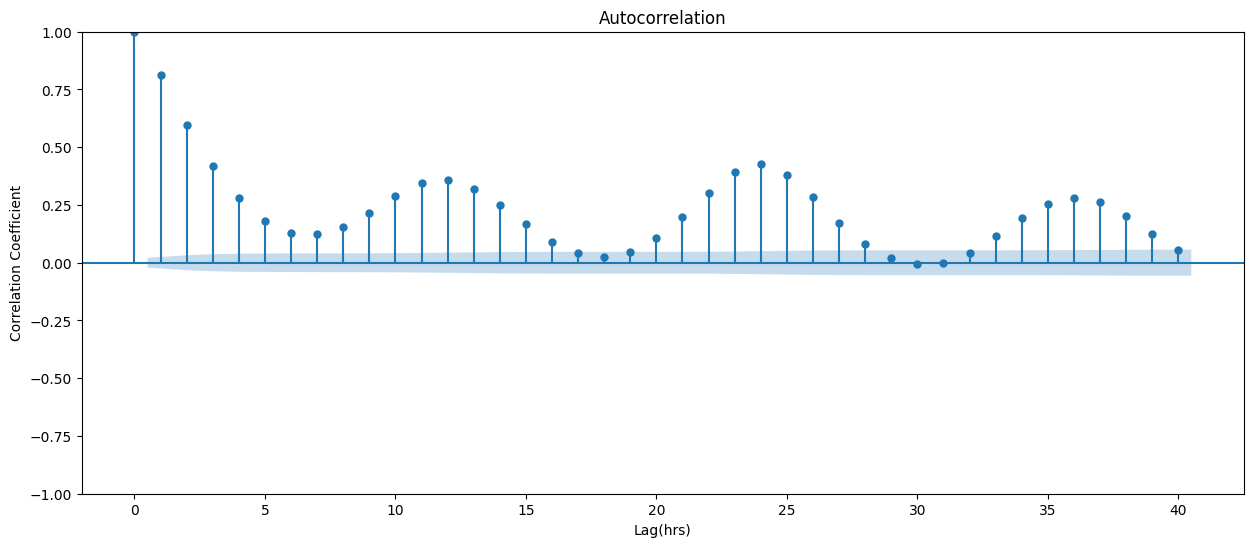

In [26]:
# ACF plot
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y, ax=ax)
plt.xlabel("Lag(hrs)")
plt.ylabel("Correlation Coefficient");

<span style="color: green;"> Since autocorrelations consider direct observations (at fixed intervals) and indirect ones (in between). We shall also plot Partial autocorrelation (PACF) since it focuses only on direct observations.  A slow drop in ACF suggests it best fits the time series, while a slow PACF drop indicates the opposite. Stripping indirect observations can clarify patterns and improve model selection for analyzing time series data effectively. <span>

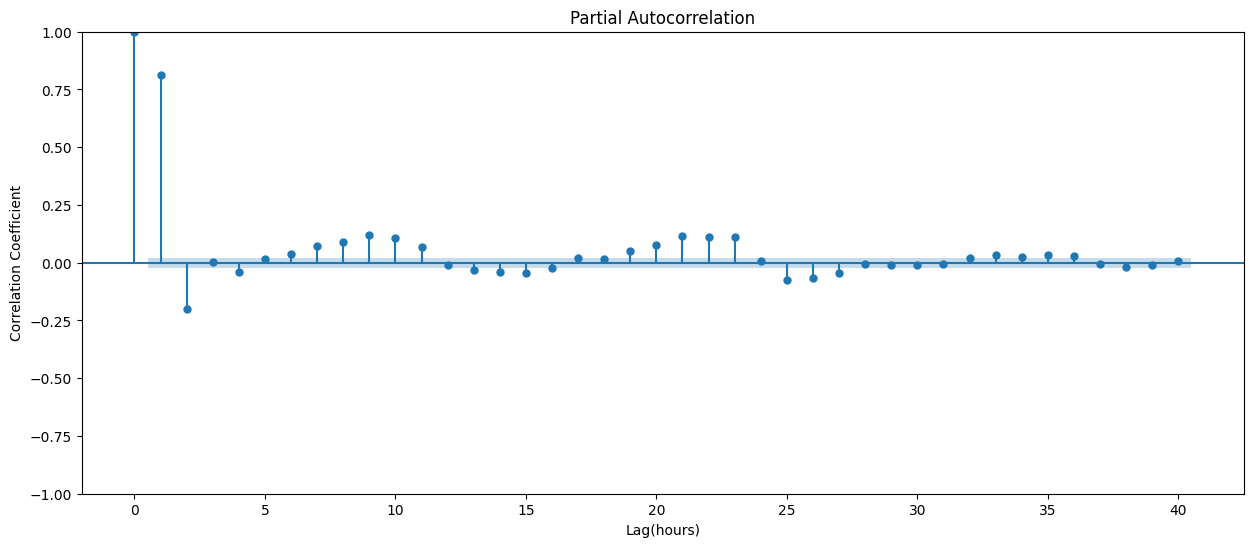

In [27]:
# PACF plot
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y, ax=ax)
plt.xlabel("Lag(hours)")
plt.ylabel("Correlation Coefficient");

<span style="color: green;"> The PACF plot above shows a strong correlation at lag 1, suggesting the time series heavily depends on its immediate past value. Most other lags fall within the confidence interval, indicating they are not statistically significant. This pattern suggests the data may follow an AR(1) model, meaning only the first lag is relevant for predictive analysis. We can also note that after 26 lags, we cannot make any sense on predictions. <span>

## 5. Modelling

### 5.1. Splitting the data

Since the dataset is large and our computation power may not be that huge. We shall only use 1% of our dataset as the test data.

In [66]:
# Splitting the data into train and test sets

cutoff = int(len(y)*0.99) # The point at which we split the data
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [67]:
# Checking the size of the train and test sets
print(y.shape)
print(y_train.shape)
print(y_test.shape)


(8476,)
(8391,)
(85,)


### 5.2. Baseline model

We shall use the mean of the data as our baseline. This is the simplest model used as a point of comparison in our predictive modeling. It provides a benchmark to evaluate the performance of more complex models to come. 

In [68]:
# Baseline model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)

mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 21.36
Baseline MAE: 7.53


### 5.3. AutoRegressive Model

In [69]:
# Instantiting and fitting the AutoReg model
model = AutoReg(y_train,lags=26).fit()

In [70]:
# Predicting and Evaluating the model

y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:], y_pred)
print("Training MAE:", round(training_mae,2))


Training MAE: 3.51


In [71]:
# Evaluating using the test set

y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", round(test_mae,2))

Test MAE: 6.67


The AR model tends to be performing better than the training set but poor on the test data. Although slightly better than the baseline model.

### 5.4. ARMA Model

ARMA and ARIMA models of the time series do have paramaters p and q. The p parameters is the AutoRegressive Order and the q parameter is the Moving average order. We set our p range between 0 and 25 since our lag is 26 and 8 as the step since we shall be getting more samples without overburdening our system.

In [83]:
# Hyperparameters

p_params = range(0,25,8)
q_params = range(0,1,1)

In [84]:
# Create dictionary to store Mean Absolute Errors

mae_grid = dict()
# Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # IIterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model and setting 0 since we are using ARMA
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARMA (0, 0, 0) in 5.52 seconds.
Trained ARMA (8, 0, 0) in 12.23 seconds.
Trained ARMA (16, 0, 0) in 48.04 seconds.
Trained ARMA (24, 0, 0) in 153.45 seconds.

{0: [7.532878644807582], 8: [3.706441240666827], 16: [3.6231901790914893], 24: [3.534602652156374]}


In [85]:
# Create a dataframe for the Mean Absolute Errors

mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,7.5329,3.7064,3.6232,3.5346


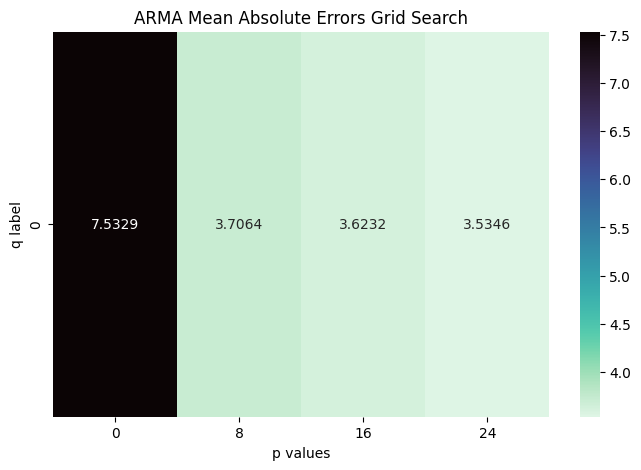

In [86]:
# Create heatmap for mae_df

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(mae_df, annot=True, ax=ax, cmap="mako_r", fmt='.5g')
plt.xlabel("p values")
plt.ylabel("q label")
plt.title("ARMA Mean Absolute Errors Grid Search");

We shall use the Trained ARMA (24, 0, 0) in 59.04 seconds. It is not the best model but it takes relatively a smaller amount of time to train.

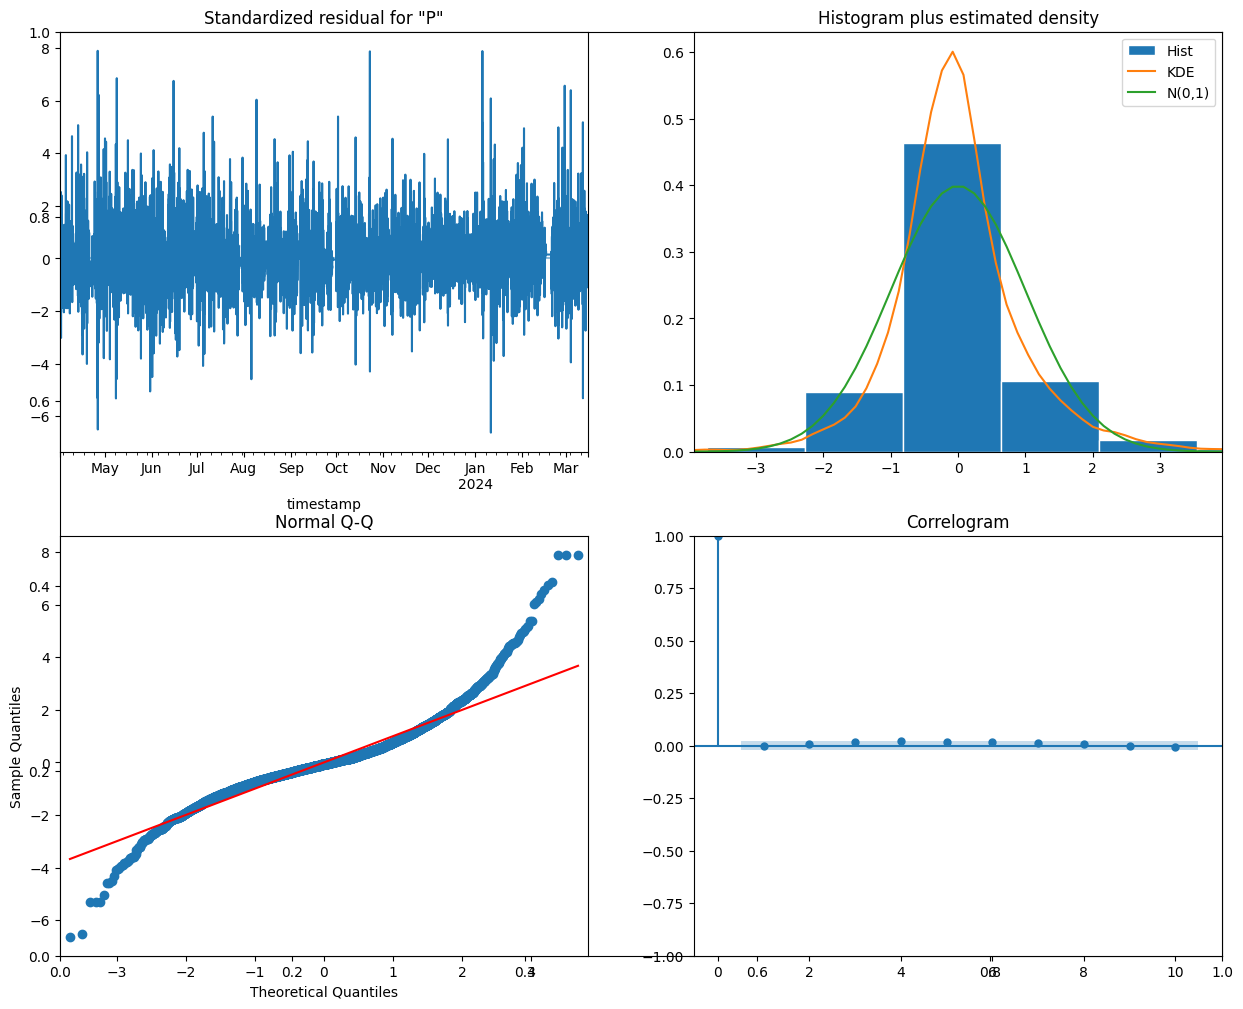

In [87]:
# Plotting  diagnostic plot

fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

#### Perfoming a Walk-Forward Validation

In [88]:
# Walk-Forward Validation

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(24,0,0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

In [89]:
# Evaluating using the test set

test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.96


A Test MAE (walk forward validation): 2.96 is not bad, and though our sample test data is small, we can still conclude that our model will work fine.

In [91]:
# Plotting to check how the model fits

df_pred_test = pd.DataFrame(
        {
        "y_test":y_test,
         "y_pred_wfv":y_pred_wfv   
        }
)

fig = px.line(df_pred_test, labels={"value":"PM2.5"}, title="Walk-Forward Validation")
fig.show()

## 6. Conclusion

The walk-forward validation plot of the performance of the ARMA model shows actual values of PM2.5-y_test, against predicted values of PM2.5-y_pred_wfv. The model is performing reasonably well to track the overall trend in PM2.5 concentration, although with some deviations in certain peaks and troughs. In this, discrepancies can be seen in the case of a rapid fluctuation or extreme values, and thus scope for improvement exists on capturing sudden changes. The alignment between predictions and actual values suggests the model is suitable for short-term forecasting but may struggle with unexpected patterns or noise in the data.

## 7. Recommendation

a). Model refinement: This include other ARMA configurations, including higher orders, should be tried to achieve better precision.

b). Include exogenous variables: Introduce explanatory variables such as weather or traffic for multivariate modeling to explain such complex dynamics.

c). Compare with other models: Check other advanced models, such as ARIMA or machine learning techniques, for better performance.

d). Optimize training data: More or diverse data will help in generalizing the predictions.